In [9]:
import os, random, datetime, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from sklearn.metrics import classification_report, confusion_matrix, precision_score

from docx import Document
from docx.shared import Inches
from pathlib import Path

print("TensorFlow:", tf.__version__)
import sklearn, umap
print("scikit-learn:", sklearn.__version__)
print("umap-learn:", umap.__version__)

SEED = 123
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# GPUÿü
print("GPU:", tf.config.list_physical_devices('GPU'))


ModuleNotFoundError: No module named 'exceptions'

In [8]:
pip install exceptions

ERROR: Could not find a version that satisfies the requirement exceptions (from versions: none)
ERROR: No matching distribution found for exceptions


In [12]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/nail_dataset'
results_dir  = '/content/drive/MyDrive/nail_results_vgg16'
os.makedirs(results_dir, exist_ok=True)
print("Results ->", results_dir)


ValueError: Mountpoint must not already contain files

In [4]:
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

# Augmentation ŸÑŸÑÿ™ÿØÿ±Ÿäÿ®
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
])

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

preprocess = tf.keras.applications.vgg16.preprocess_input
train_ds = (train_ds.map(lambda x,y: (preprocess(x), y), num_parallel_calls=AUTOTUNE)
                    .cache().shuffle(1000).prefetch(AUTOTUNE))
val_ds   = (val_ds.map(lambda x,y: (preprocess(x), y), num_parallel_calls=AUTOTUNE)
                  .cache().prefetch(AUTOTUNE))


NameError: name 'dataset_path' is not defined

## **VGG16**

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # ŸÜÿ¨ŸÖŸëÿØ ÿ®ÿßŸÑÿ®ÿØÿßŸäÿ©

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_1 (InputLayer)      ‚îÇ (None, 224, 224, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ sequential (Sequential)         ‚îÇ (None, 224, 224, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ vgg16 (Functional)              ‚îÇ (None, 7, 7, 512)      ‚îÇ    14,714,688 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d        ‚îÇ (None, 512)            ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 256)            ‚îÇ       131,328 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 6)              ‚îÇ         1,542 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 14,847,558 (56.64 MB)

 Trainable params: 132,870 (519.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
ckpt_path = os.path.join(results_dir, "best_vgg16.keras")
csv_log   = os.path.join(results_dir, "train_log.csv")

callbacks = [
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=5, mode="max", restore_best_weights=True, verbose=1),
    CSVLogger(csv_log)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18s/step - accuracy: 0.6159 - loss: 1.7654 
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/nail_results_vgg16/best_vgg16.keras
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1206s 22s/step - accuracy: 0.6205 - loss: 1.7422 - val_accuracy: 1.0000 - val_loss: 3.3651e-04
Epoch 2/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18s/step - accuracy: 0.9964 - loss: 0.0198 
Epoch 2: val_accuracy did not improve from 1.00000
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 999s 22s/step - accuracy: 0.9964 - loss: 0.0198 - val_accuracy: 1.0000 - val_loss: 2.2634e-04
Epoch 3/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18s/step - accuracy: 0.9966 - loss: 0.0119 
Epoch 3: val_accuracy did not improve from 1.00000
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 991s 

In [ ]:
# ÿ™ÿ¨ŸÖŸäÿπ ÿßŸÑŸÅÿßŸÑÿØŸäÿ¥ŸÜ ŸÅŸä ŸÖÿµŸÅŸàŸÅÿßÿ™
val_images, val_labels = [], []
for bx, by in val_ds:
    val_images.append(bx.numpy()); val_labels.append(by.numpy())
val_images = np.concatenate(val_images, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

probs  = model.predict(val_images, batch_size=BATCH_SIZE)
y_pred = probs.argmax(axis=1)

acc  = (y_pred == val_labels).mean()
loss = tf.keras.losses.sparse_categorical_crossentropy(val_labels, probs).numpy().mean()
precision_macro    = precision_score(val_labels, y_pred, average="macro", zero_division=0)
precision_weighted = precision_score(val_labels, y_pred, average="weighted", zero_division=0)

print({"Accuracy": round(float(acc),4),
       "Loss": round(float(loss),4),
       "Precision_macro": round(float(precision_macro),4),
       "Precision_weighted": round(float(precision_weighted),4)})


12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 201s 16s/step
{'Accuracy': 1.0, 'Loss': 0.0003, 'Precision_macro': 1.0, 'Precision_weighted': 1.0}


In [ ]:
report_df = pd.DataFrame(
    classification_report(val_labels, y_pred, target_names=class_names, output_dict=True)
).transpose()
report_csv = os.path.join(results_dir, "classification_report.csv")
report_df.to_csv(report_csv)
report_df.head()


precision  recall  f1-score  support
almond nail         1.0     1.0       1.0     52.0
coffin nail         1.0     1.0       1.0     75.0
round nail          1.0     1.0       1.0     57.0
square nail         1.0     1.0       1.0     58.0
squoval nail        1.0     1.0       1.0     62.0

In [ ]:
cm = confusion_matrix(val_labels, y_pred, labels=range(num_classes))
cm_csv = os.path.join(results_dir, "confusion_matrix.csv")
np.savetxt(cm_csv, cm, fmt="%d", delimiter=",")
cm


array([[52,  0,  0,  0,  0,  0],
       [ 0, 75,  0,  0,  0,  0],
       [ 0,  0, 57,  0,  0,  0],
       [ 0,  0,  0, 58,  0,  0],
       [ 0,  0,  0,  0, 62,  0],
       [ 0,  0,  0,  0,  0, 56]])

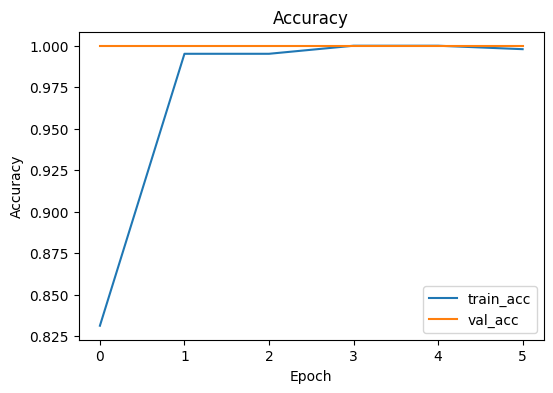

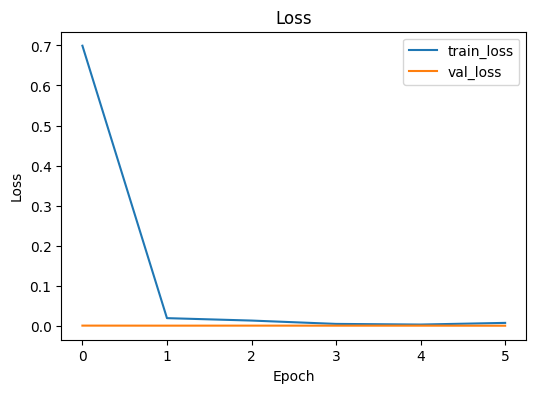

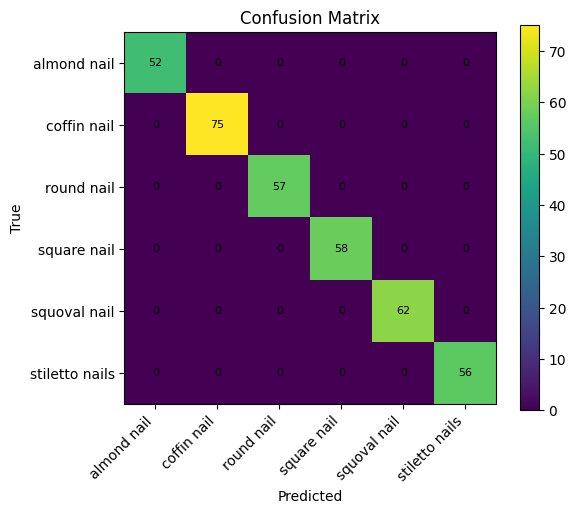

('/content/drive/MyDrive/nail_results_vgg16/accuracy_curve.png',
 '/content/drive/MyDrive/nail_results_vgg16/loss_curve.png',
 '/content/drive/MyDrive/nail_results_vgg16/confusion_matrix.png')

In [ ]:
hist = history.history

plt.figure(figsize=(6,4))
plt.plot(hist["accuracy"], label="train_acc")
plt.plot(hist["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")
acc_png = os.path.join(results_dir, "accuracy_curve.png")
plt.savefig(acc_png, dpi=150, bbox_inches="tight"); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")
loss_png = os.path.join(results_dir, "loss_curve.png")
plt.savefig(loss_png, dpi=150, bbox_inches="tight"); plt.show()

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix"); plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, class_names, rotation=45, ha="right")
plt.yticks(ticks, class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
for i, j in itertools.product(range(num_classes), range(num_classes)):
    plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
cm_png = os.path.join(results_dir, "confusion_matrix.png")
plt.savefig(cm_png, dpi=150, bbox_inches="tight"); plt.show()

(acc_png, loss_png, cm_png)


In [ ]:
counts, samples = [], []
for cname in class_names:
    class_dir = Path(dataset_path)/cname
    files = sorted([p for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp") for p in class_dir.glob(ext)])
    counts.append(len(files))
    samples.append(str(files[0]) if files else "")

dataset_summary_df = pd.DataFrame({
    "Class Name": class_names,
    "Total Images": counts,
    "Sample Image Path": samples
})
dataset_summary_csv = os.path.join(results_dir, "dataset_summary.csv")
dataset_summary_df.to_csv(dataset_summary_csv, index=False)
dataset_summary_df


Class Name  Total Images  \
0     almond nail           300   
1     coffin nail           300   
2      round nail           300   
3     square nail           300   
4    squoval nail           300   
5  stiletto nails           300   

                                   Sample Image Path  
0  /content/drive/MyDrive/nail_dataset/almond nai...  
1  /content/drive/MyDrive/nail_dataset/coffin nai...  
2  /content/drive/MyDrive/nail_dataset/round nail...  
3  /content/drive/MyDrive/nail_dataset/square nai...  
4  /content/drive/MyDrive/nail_dataset/squoval na...  
5  /content/drive/MyDrive/nail_dataset/stiletto n...

In [ ]:
metrics_row = {
    "Model": "VGG16",
    "Accuracy": round(float(acc), 4),
    "Precision_macro": round(float(precision_macro), 4),
    "Precision_weighted": round(float(precision_weighted), 4),
    "Loss": round(float(loss), 4),
    "Timestamp": datetime.datetime.now().isoformat(timespec="seconds")
}
metrics_df = pd.DataFrame([metrics_row])
metrics_csv = os.path.join(results_dir, "metrics.csv")
metrics_df.to_csv(metrics_csv, index=False)
metrics_df


Model  Accuracy  Precision_macro  Precision_weighted    Loss  \
0  VGG16       1.0              1.0                 1.0  0.0003   

             Timestamp  
0  2025-09-05T18:49:05

In [ ]:
docx_path = os.path.join(results_dir, "VGG16_Results.docx")
doc = Document()

doc.add_heading('VGG16 Results', level=1)

doc.add_heading('Summary Metrics', level=2)
t = doc.add_table(rows=2, cols=4)
hdr = t.rows[0].cells
hdr[0].text, hdr[1].text, hdr[2].text, hdr[3].text = 'Accuracy','Precision (macro)','Precision (weighted)','Loss'
row = t.rows[1].cells
row[0].text = f"{metrics_row['Accuracy']:.4f}"
row[1].text = f"{metrics_row['Precision_macro']:.4f}"
row[2].text = f"{metrics_row['Precision_weighted']:.4f}"
row[3].text = f"{metrics_row['Loss']:.4f}"

doc.add_paragraph()
doc.add_heading('Training Curves & Confusion Matrix', level=2)
for p in [os.path.join(results_dir,"accuracy_curve.png"),
          os.path.join(results_dir,"loss_curve.png"),
          os.path.join(results_dir,"confusion_matrix.png")]:
    if os.path.exists(p):
        doc.add_picture(p, width=Inches(5.5))

doc.add_paragraph()
doc.add_heading('Classification Report (CSV attached)', level=2)
doc.add_paragraph(Path(report_csv).name)

doc.add_heading('Dataset Summary', level=2)
t2 = doc.add_table(rows=1+len(dataset_summary_df), cols=3)
t2.rows[0].cells[0].text = 'Class Name'
t2.rows[0].cells[1].text = 'Total Images'
t2.rows[0].cells[2].text = 'Sample Image'
for i, r in dataset_summary_df.iterrows():
    t2.rows[i+1].cells[0].text = str(r['Class Name'])
    t2.rows[i+1].cells[1].text = str(r['Total Images'])
    t2.rows[i+1].cells[2].text = Path(str(r['Sample Image Path'])).name if r['Sample Image Path'] else "-"

doc.add_paragraph()
doc.add_paragraph("Attached files:")
for p in [metrics_csv, report_csv, cm_csv, dataset_summary_csv]:
    doc.add_paragraph("- " + Path(p).name)

doc.save(docx_path)
docx_path


'/content/drive/MyDrive/nail_results_vgg16/VGG16_Results.docx'

In [7]:
# Ÿäÿ≥ÿßÿπÿØŸÜÿß ŸÜÿπŸäÿØ ÿ™ÿ≠ŸÖŸäŸÑ ÿßŸÑÿØÿßÿ™ÿßÿ≥ÿ™ ŸÖÿπ ÿ£Ÿä preprocess ÿ™ÿÆÿ™ÿßÿ±ŸäŸÜŸá
def make_datasets(dataset_path, img_size, batch_size, seed, preprocess_fn):
    AUTOTUNE = tf.data.AUTOTUNE
    train_raw = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path, validation_split=0.2, subset="training",
        seed=seed, image_size=img_size, batch_size=batch_size
    )
    val_raw = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path, validation_split=0.2, subset="validation",
        seed=seed, image_size=img_size, batch_size=batch_size
    )
    class_names = train_raw.class_names
    num_classes = len(class_names)
    train_ds = (train_raw.map(lambda x,y: (preprocess_fn(x), y), num_parallel_calls=AUTOTUNE)
                        .cache().shuffle(1000).prefetch(AUTOTUNE))
    val_ds   = (val_raw.map(lambda x,y: (preprocess_fn(x), y), num_parallel_calls=AUTOTUNE)
                        .cache().prefetch(AUTOTUNE))
    return train_ds, val_ds, class_names, num_classes


In [11]:
def evaluate_and_report(model, history, MODEL_NAME, results_dir,
                        val_ds, class_names, num_classes,
                        BATCH_SIZE, dataset_path):
    import numpy as np, pandas as pd, datetime, itertools, os
    import matplotlib.pyplot as plt
    from pathlib import Path
    from sklearn.metrics import classification_report, confusion_matrix, precision_score
    from docx import Document
    from docx.shared import Inches
    import tensorflow as tf

    # ÿ¨ŸÖÿπ ÿ®ŸäÿßŸÜÿßÿ™ ÿßŸÑŸÅÿßŸÑÿØŸäÿ¥ŸÜ
    val_images, val_labels = [], []
    for bx, by in val_ds:
        val_images.append(bx.numpy()); val_labels.append(by.numpy())
    val_images = np.concatenate(val_images, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)

    # ÿ™ŸÜÿ®ÿ§ÿßÿ™ ŸàŸÖŸÇÿßŸäŸäÿ≥
    probs  = model.predict(val_images, batch_size=BATCH_SIZE, verbose=0)
    y_pred = probs.argmax(axis=1)
    acc  = (y_pred == val_labels).mean()
    loss = tf.keras.losses.sparse_categorical_crossentropy(val_labels, probs).numpy().mean()
    precision_macro    = precision_score(val_labels, y_pred, average="macro", zero_division=0)
    precision_weighted = precision_score(val_labels, y_pred, average="weighted", zero_division=0)
    print({"Accuracy": round(float(acc),4),
           "Loss": round(float(loss),4),
           "Precision_macro": round(float(precision_macro),4),
           "Precision_weighted": round(float(precision_weighted),4)})

    # ÿ™ŸÇÿßÿ±Ÿäÿ± CSV
    report_df = pd.DataFrame(classification_report(val_labels, y_pred, target_names=class_names, output_dict=True)).transpose()
    report_csv = os.path.join(results_dir, "classification_report.csv")
    report_df.to_csv(report_csv)

    cm = confusion_matrix(val_labels, y_pred, labels=range(num_classes))
    cm_csv = os.path.join(results_dir, "confusion_matrix.csv")
    np.savetxt(cm_csv, cm, fmt="%d", delimiter=",")

    # ŸÖŸÜÿ≠ŸÜŸäÿßÿ™ ÿßŸÑÿ™ÿØÿ±Ÿäÿ® + ŸÖÿµŸÅŸàŸÅÿ© ÿßŸÑÿßŸÑÿ™ÿ®ÿßÿ≥ (ÿµŸàÿ±)
    hist = history.history
    acc_png  = os.path.join(results_dir, "accuracy_curve.png")
    loss_png = os.path.join(results_dir, "loss_curve.png")
    cm_png   = os.path.join(results_dir, "confusion_matrix.png")

    plt.figure(figsize=(6,4))
    plt.plot(hist["accuracy"], label="train_acc")
    plt.plot(hist["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")
    plt.savefig(acc_png, dpi=150, bbox_inches="tight"); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist["loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")
    plt.savefig(loss_png, dpi=150, bbox_inches="tight"); plt.show()

    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix"); plt.colorbar()
    ticks = np.arange(num_classes)
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)
    plt.xlabel("Predicted"); plt.ylabel("True")
    for i, j in itertools.product(range(num_classes), range(num_classes)):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
    plt.savefig(cm_png, dpi=150, bbox_inches="tight"); plt.show()

    # ŸÖŸÑÿÆÿµ ÿßŸÑÿØÿßÿ™ÿß (ÿπÿØÿØ ÿßŸÑÿµŸàÿ± + ÿπŸäŸÜÿ©)
    counts, samples = [], []
    for cname in class_names:
        class_dir = Path(dataset_path) / cname
        files = sorted([p for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp") for p in class_dir.glob(ext)])
        counts.append(len(files))
        samples.append(str(files[0]) if files else "")
    dataset_summary_df = pd.DataFrame({"Class Name": class_names, "Total Images": counts, "Sample Image Path": samples})
    dataset_summary_csv = os.path.join(results_dir, "dataset_summary.csv")
    dataset_summary_df.to_csv(dataset_summary_csv, index=False)

    # ÿ≠ŸÅÿ∏ ÿµŸÅ ÿßŸÑŸÖŸÇÿßŸäŸäÿ≥ ÿßŸÑŸÖÿÆÿ™ÿµÿ± + Word
    metrics_row = {
        "Model": MODEL_NAME,
        "Accuracy": round(float(acc), 4),
        "Precision_macro": round(float(precision_macro), 4),
        "Precision_weighted": round(float(precision_weighted), 4),
        "Loss": round(float(loss), 4),
        "Timestamp": datetime.datetime.now().isoformat(timespec="seconds")
    }
    metrics_df = pd.DataFrame([metrics_row])
    metrics_csv = os.path.join(results_dir, "metrics.csv")
    metrics_df.to_csv(metrics_csv, index=False)

    docx_path = os.path.join(results_dir, f"{MODEL_NAME}_Results.docx")
    doc = Document()
    doc.add_heading(f'{MODEL_NAME} Results', 1)

    # ÿ¨ÿØŸàŸÑ ÿßŸÑŸÖŸÇÿßŸäŸäÿ≥
    doc.add_heading('Summary Metrics', level=2)
    t = doc.add_table(rows=2, cols=4)
    hdr = t.rows[0].cells
    hdr[0].text, hdr[1].text, hdr[2].text, hdr[3].text = 'Accuracy','Precision (macro)','Precision (weighted)','Loss'
    row = t.rows[1].cells
    row[0].text = f"{metrics_row['Accuracy']:.4f}"
    row[1].text = f"{metrics_row['Precision_macro']:.4f}"
    row[2].text = f"{metrics_row['Precision_weighted']:.4f}"
    row[3].text = f"{metrics_row['Loss']:.4f}"

    doc.add_paragraph()
    doc.add_heading('Training Curves & Confusion Matrix', level=2)
    for p in [acc_png, loss_png, cm_png]:
        if os.path.exists(p):
            doc.add_picture(p, width=Inches(5.5))

    doc.add_paragraph()
    doc.add_heading('Classification Report (CSV attached)', level=2)
    doc.add_paragraph(Path(report_csv).name)

    doc.add_heading('Dataset Summary', level=2)
    t2 = doc.add_table(rows=1+len(dataset_summary_df), cols=3)
    t2.rows[0].cells[0].text = 'Class Name'
    t2.rows[0].cells[1].text = 'Total Images'
    t2.rows[0].cells[2].text = 'Sample Image'
    for i, r in dataset_summary_df.iterrows():
        t2.rows[i+1].cells[0].text = str(r['Class Name'])
        t2.rows[i+1].cells[1].text = str(r['Total Images'])
        t2.rows[i+1].cells[2].text = Path(str(r['Sample Image Path'])).name if r['Sample Image Path'] else "-"

    doc.add_paragraph()
    doc.add_paragraph("Attachments in folder:")
    for p in [metrics_csv, report_csv, cm_csv, dataset_summary_csv]:
        doc.add_paragraph("- " + Path(p).name)

    doc.save(docx_path)
    print("Saved Word:", docx_path)


## **VGG19**

In [ ]:
from tensorflow.keras.applications import VGG19

MODEL_NAME = "VGG19"
results_dir = f"/content/drive/MyDrive/nail_results_{MODEL_NAME.lower()}"
os.makedirs(results_dir, exist_ok=True)

# ŸÜŸÅÿ≥ preprocessing ÿ™ÿ®ÿπ VGG
preprocess = tf.keras.applications.vgg19.preprocess_input
train_ds, val_ds, class_names, num_classes = make_datasets(
    dataset_path, IMG_SIZE, BATCH_SIZE, SEED, preprocess
)

# ÿ®ŸÜÿßÿ° ÿßŸÑÿ±ÿ£ÿ≥ + ÿßŸÑÿ™ÿØÿ±Ÿäÿ®
base_model = VGG19(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,))
base_model.trainable = False
inputs = layers.Input(shape=IMG_SIZE+(3,))
x = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
])(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

ckpt_path = os.path.join(results_dir, f"best_{MODEL_NAME.lower()}.keras")
csv_log   = os.path.join(results_dir, "train_log.csv")
callbacks = [
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, mode="max", verbose=1),
    CSVLogger(csv_log)
]
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)

# ‚Äî‚Äî ÿ™ÿ¥ÿ∫ŸäŸÑ ÿ®ÿßŸÇÿ© 6‚Üí10 (ÿßŸÜÿ≥ÿÆŸä ŸÜŸÅÿ≥ ÿ≠ÿ≤ŸÖÿ© ÿßŸÑÿ™ŸÇŸäŸäŸÖ ŸàÿßŸÑŸÄ Word ÿßŸÑŸÑŸä ÿπÿ∑Ÿäÿ™ŸÉ ŸÇÿ®ŸÑÿå ÿ£Ÿà ÿ¥ÿ∫ŸëŸÑŸäŸáÿß ŸÖÿ®ÿßÿ¥ÿ±ÿ© ÿ•ŸÜŸÉŸê ŸÖÿ≠ÿ™ŸÅÿ∏ÿ© ŸÅŸäŸáÿß)


Found 1800 files belonging to 6 classes.
Using 1440 files for training.
Found 1800 files belonging to 6 classes.
Using 360 files for validation.
Epoch 1/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 22s/step - accuracy: 0.5774 - loss: 1.9468 
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/nail_results_vgg19/best_vgg19.keras
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1271s 28s/step - accuracy: 0.5823 - loss: 1.9221 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 2/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 22s/step - accuracy: 0.9863 - loss: 0.0451 
Epoch 2: val_accuracy did not improve from 1.00000
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1240s 28s/step - accuracy: 0.9864 - loss: 0.0449 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 3/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 22s/step - accuracy: 0.9879 -

{'Accuracy': 1.0, 'Loss': 0.0025, 'Precision_macro': 1.0, 'Precision_weighted': 1.0}


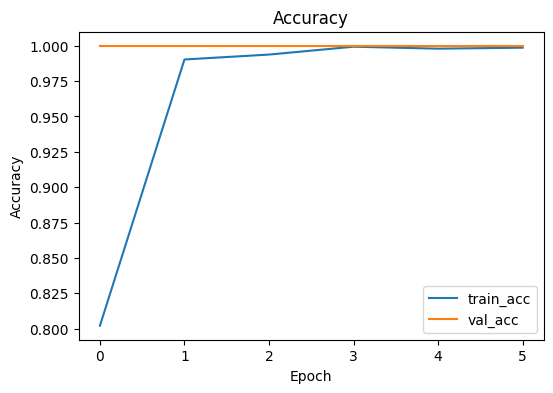

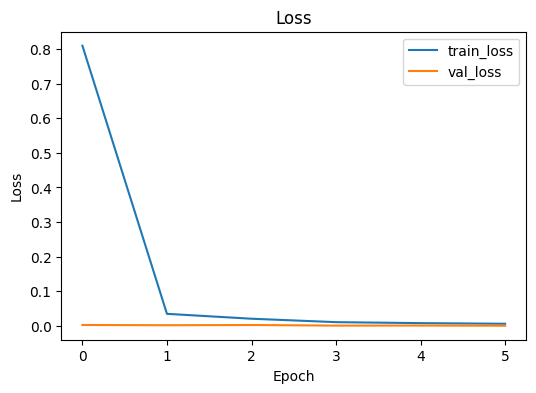

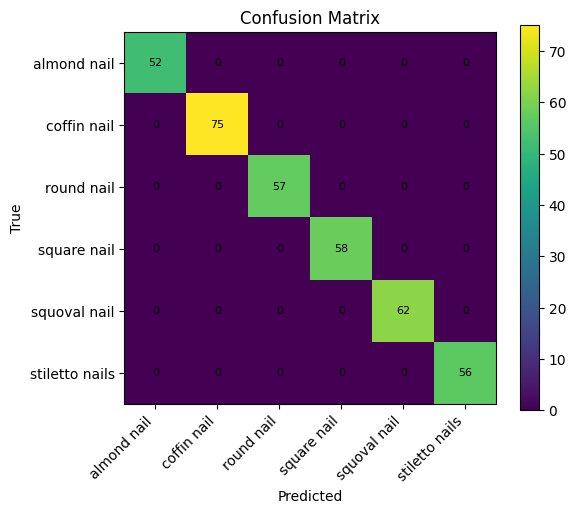

Saved Word: /content/drive/MyDrive/nail_results_vgg19/VGG19_Results.docx


In [ ]:
evaluate_and_report(model, history, MODEL_NAME, results_dir,
                    val_ds, class_names, num_classes,
                    BATCH_SIZE, dataset_path)


## **ResNet50**

In [ ]:
from tensorflow.keras.applications import ResNet50

MODEL_NAME = "ResNet50"
results_dir = f"/content/drive/MyDrive/nail_results_{MODEL_NAME.lower()}"
os.makedirs(results_dir, exist_ok=True)

preprocess = tf.keras.applications.resnet.preprocess_input
train_ds, val_ds, class_names, num_classes = make_datasets(dataset_path, IMG_SIZE, BATCH_SIZE, SEED, preprocess)

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,))
base_model.trainable = False
inputs = layers.Input(shape=IMG_SIZE+(3,))
x = layers.RandomFlip("horizontal")(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

ckpt_path = os.path.join(results_dir, f"best_{MODEL_NAME.lower()}.keras")
csv_log   = os.path.join(results_dir, "train_log.csv")
callbacks = [
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1),
    CSVLogger(csv_log)
]
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)


Found 1800 files belonging to 6 classes.
Using 1440 files for training.
Found 1800 files belonging to 6 classes.
Using 360 files for validation.
94765736/94765736 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 0us/step
Epoch 1/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6s/step - accuracy: 0.8170 - loss: 0.5922
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/nail_results_resnet50/best_resnet50.keras
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 351s 7s/step - accuracy: 0.8198 - loss: 0.5834 - val_accuracy: 1.0000 - val_loss: 2.7838e-04
Epoch 2/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6s/step - accuracy: 1.0000 - loss: 0.0029
Epoch 2: val_accuracy did not improve from 1.00000
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 352s 7s/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 9.5266e-05
Epoch 3/10
45

{'Accuracy': 1.0, 'Loss': 0.0003, 'Precision_macro': 1.0, 'Precision_weighted': 1.0}


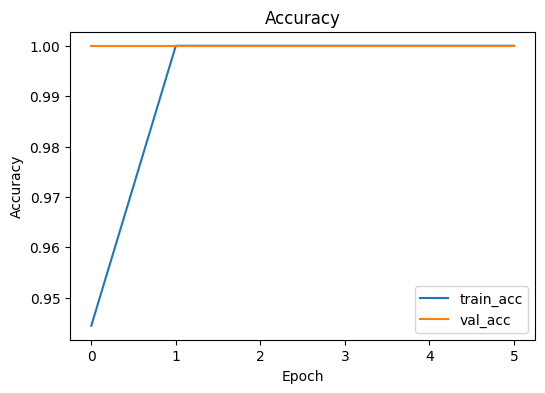

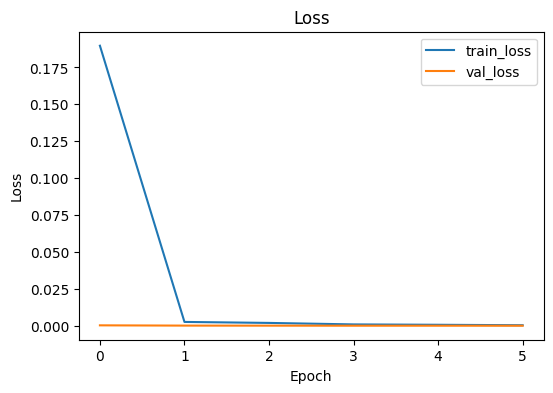

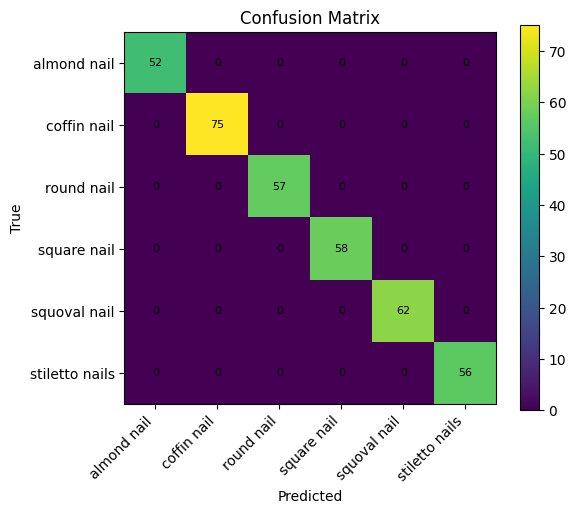

Saved Word: /content/drive/MyDrive/nail_results_resnet50/ResNet50_Results.docx


In [ ]:
evaluate_and_report(model, history, MODEL_NAME, results_dir,
                    val_ds, class_names, num_classes,
                    BATCH_SIZE, dataset_path)


## **ResNet101**

In [ ]:
from tensorflow.keras.applications import ResNet101

MODEL_NAME = "ResNet101"
results_dir = f"/content/drive/MyDrive/nail_results_{MODEL_NAME.lower()}"
os.makedirs(results_dir, exist_ok=True)

preprocess = tf.keras.applications.resnet.preprocess_input
train_ds, val_ds, class_names, num_classes = make_datasets(dataset_path, IMG_SIZE, BATCH_SIZE, SEED, preprocess)

base_model = ResNet101(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,))
base_model.trainable = False
inputs = layers.Input(shape=IMG_SIZE+(3,))
x = layers.RandomFlip("horizontal")(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

ckpt_path = os.path.join(results_dir, f"best_{MODEL_NAME.lower()}.keras")
csv_log   = os.path.join(results_dir, "train_log.csv")
callbacks = [
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1),
    CSVLogger(csv_log)
]
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)


Found 1800 files belonging to 6 classes.
Using 1440 files for training.
Found 1800 files belonging to 6 classes.
Using 360 files for validation.
Epoch 1/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10s/step - accuracy: 0.7968 - loss: 0.7463 
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/nail_results_resnet101/best_resnet101.keras
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 613s 13s/step - accuracy: 0.7997 - loss: 0.7354 - val_accuracy: 1.0000 - val_loss: 7.2165e-04
Epoch 2/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10s/step - accuracy: 1.0000 - loss: 0.0034
Epoch 2: val_accuracy did not improve from 1.00000
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 556s 12s/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 1.8511e-04
Epoch 3/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10s/step - accur

{'Accuracy': 1.0, 'Loss': 0.0007, 'Precision_macro': 1.0, 'Precision_weighted': 1.0}


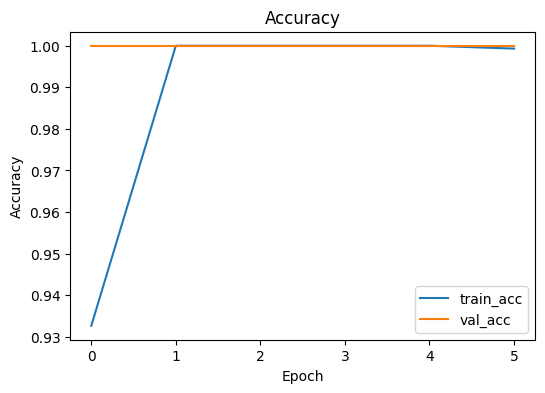

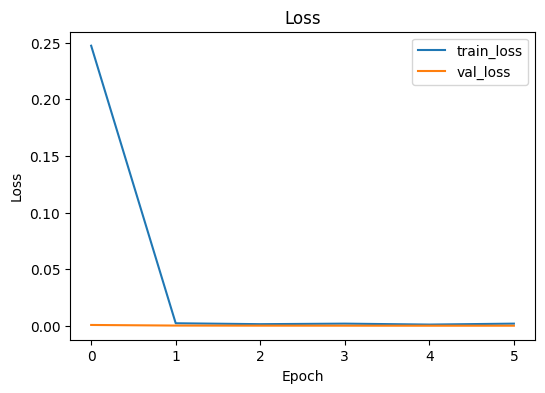

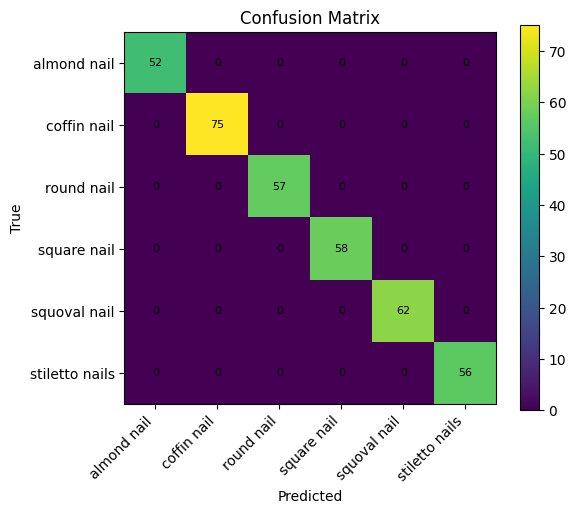

Saved Word: /content/drive/MyDrive/nail_results_resnet101/ResNet101_Results.docx


In [ ]:
evaluate_and_report(model, history, MODEL_NAME, results_dir,
                    val_ds, class_names, num_classes,
                    BATCH_SIZE, dataset_path)


## **ViT-B16**

In [1]:
# ===================== ÿ™ŸÜÿµŸäÿ® ÿßŸÑÿ≠ÿ≤ŸÖ =====================
!pip -q install timm python-docx tqdm

# ===================== ÿßŸÑÿßÿ≥ÿ™Ÿäÿ±ÿßÿØ =====================
import os, gc, math, random, glob
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from PIL import ImageFile
import timm
from tqdm import tqdm

# ŸÅŸä ÿ≠ÿßŸÑ Ÿàÿ¨ŸàÿØ ÿµŸàÿ± ŸÜÿßŸÇÿµÿ©
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ===================== ÿ•ÿπÿØÿßÿØÿßÿ™ ÿπÿßŸÖÿ© =====================
img_size    = 224
batch_size  = 16   # ÿÆŸÅŸäŸÅ ÿπŸÑŸâ ŸÉŸàŸÑÿßÿ®
num_epochs  = 10
seed        = 42
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(seed)
random.seed(seed)

if device.type == "cuda":
    torch.cuda.manual_seed_all(seed)

# ===================== Google Drive =====================
from google.colab import drive
drive.mount('/content/drive')

# ŸÖÿ≥ÿßÿ± ÿ®ŸäÿßŸÜÿßÿ™ŸÉ (ŸÉŸÑ ŸÅÿ¶ÿ© ÿØÿßÿÆŸÑ ŸÖÿ¨ŸÑÿØ ÿ®ÿßÿ≥ŸÖŸáÿß)
dataset_path = '/content/drive/MyDrive/nail_dataset'

# ŸÖÿ¨ŸÑÿØ ÿßŸÑŸÜÿ™ÿßÿ¶ÿ¨
results_dir = "/content/drive/MyDrive/nail_results_vit_b16_torch"
os.makedirs(results_dir, exist_ok=True)
best_path = os.path.join(results_dir, "best_vit_b16_torch.pt")

# ===================== ÿßŸÑÿ™ÿ≠ŸàŸäŸÑÿßÿ™ =====================
train_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ===================== ÿ™ÿ≠ŸÖŸäŸÑ ÿßŸÑÿ®ŸäÿßŸÜÿßÿ™ =====================
full_ds = datasets.ImageFolder(root=dataset_path, transform=train_tf)  # ŸÜŸÅÿ≥ ÿßŸÑÿ™ÿ≠ŸàŸäŸÑ ŸÑŸÑÿ™ŸÇÿ≥ŸäŸÖ
num_samples = len(full_ds.samples)
indices     = torch.randperm(num_samples)
split       = int(0.8 * num_samples)
train_idx   = indices[:split]
val_idx     = indices[split:]

# ŸÜÿ≥ÿ™ÿÆÿØŸÖ ÿ™ÿ≠ŸàŸäŸÑŸäŸíŸÜ ŸÖÿÆÿ™ŸÑŸÅŸäŸíŸÜ ŸÑŸÑÿ™ÿØÿ±Ÿäÿ®/ÿßŸÑÿ™ÿ≠ŸÇŸÇ
train_base = datasets.ImageFolder(root=dataset_path, transform=train_tf)
val_base   = datasets.ImageFolder(root=dataset_path, transform=val_tf)

train_ds = Subset(train_base, train_idx)
val_ds   = Subset(val_base,   val_idx)

class_names = train_base.classes
num_classes = len(class_names)
print(f"Found {num_samples} images in {num_classes} classes:", class_names)

loader_kwargs = dict(
    batch_size=batch_size,
    pin_memory=(device.type=="cuda"),
    num_workers=0,
    persistent_workers=False
)
train_loader = DataLoader(train_ds, shuffle=True,  drop_last=False, **loader_kwargs)
val_loader   = DataLoader(val_ds,   shuffle=False, drop_last=False, **loader_kwargs)

# ===================== ÿßŸÑŸÖŸàÿØŸäŸÑ =====================
# ŸÑŸà ÿßŸÑÿ∞ÿßŸÉÿ±ÿ© ÿ∂ÿπŸäŸÅÿ© ÿ®ÿØŸëŸÑŸä ÿ•ŸÑŸâ: 'vit_tiny_patch16_224'
model_name = 'vit_base_patch16_224'
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

# ===================== ÿßŸÑÿ™ÿØÿ±Ÿäÿ® =====================
train_acc_hist, train_loss_hist = [], []
val_acc_hist,   val_loss_hist   = [], []

best_val_acc = 0.0

for epoch in range(num_epochs):
    # ---- Train ----
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total   += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=float(loss.item()), acc=float(correct/max(total,1)))

    train_loss = running_loss / max(len(train_loader),1)
    train_acc  = correct / max(total,1)
    train_acc_hist.append(train_acc)
    train_loss_hist.append(train_loss)

    # ---- Validate ----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.inference_mode():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total   += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= max(len(val_loader),1)
    val_acc   = val_correct / max(val_total,1)
    val_acc_hist.append(val_acc)
    val_loss_hist.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f} - "
          f"Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

    # ÿ≠ŸÅÿ∏ ÿ£ŸÅÿ∂ŸÑ ŸÜŸÖŸàÿ∞ÿ¨
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "state_dict": model.state_dict(),
            "class_names": class_names,
            "model_name": model_name,
            "img_size": img_size
        }, best_path)
        print(f"‚úÖ Saved best model to: {best_path} (val_acc={best_val_acc:.4f})")

    # ÿ™ŸÅÿ±Ÿäÿ∫ ÿßŸÑÿ∞ÿßŸÉÿ±ÿ©
    if device.type == "cuda":
        torch.cuda.empty_cache()
    gc.collect()

print("‚ö°Ô∏è Training done. Best Val Acc:", best_val_acc)


   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 253.0/253.0 kB 9.2 MB/s eta 0:00:00
Mounted at /content/drive
Found 1800 images in 6 classes: ['almond nail', 'coffin nail', 'round nail', 'square nail', 'squoval nail', 'stiletto nails']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/tmp/ipython-input-3815398770.py:95: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
Epoch 1/10:   0%|          | 0/90 [00:00<?, ?it/s]/tmp/ipython-input-3815398770.py:113: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipython-input-3815398770.py:139: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 1/10 - Train Acc: 0.9611, Train Loss: 0.1176 - Val Acc: 1.0000, Val Loss: 0.0001
‚úÖ Saved best model to: /content/drive/MyDrive/nail_results_vit_b16_torch/best_vit_b16_torch.pt (val_acc=1.0000)


Epoch 2/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000


Epoch 3/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000


Epoch 4/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000


Epoch 5/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000


Epoch 6/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000


Epoch 7/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000


Epoch 8/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000


Epoch 9/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000


Epoch 10/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000
‚ö°Ô∏è Training done. Best Val Acc: 1.0


{'Accuracy': 1.0, 'Loss': 0.0, 'Precision_macro': 1.0, 'Precision_weighted': 1.0}


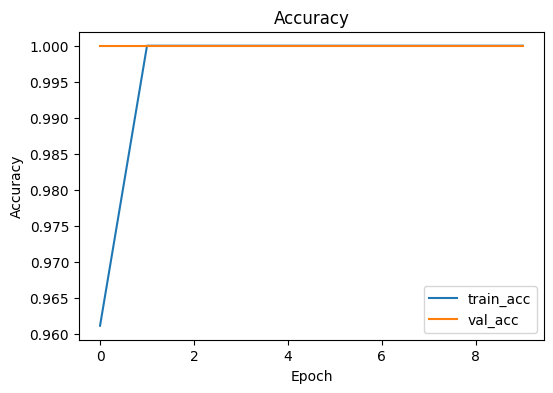

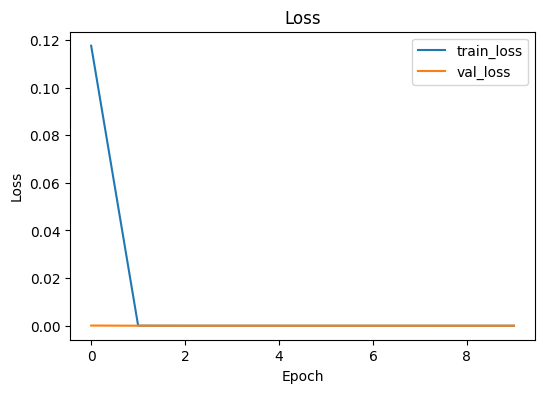

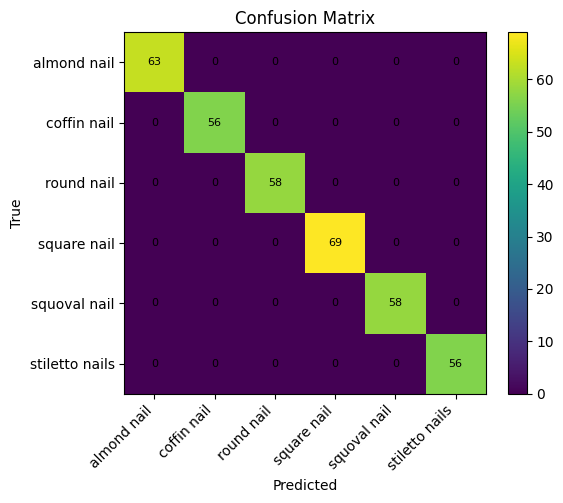

Saved Word: /content/drive/MyDrive/nail_results_vit_b16_torch/ViT_B16_timm_Results.docx
Folder: /content/drive/MyDrive/nail_results_vit_b16_torch


In [2]:
# ===================== ÿßŸÑÿ™ŸÇŸäŸäŸÖ ŸàÿßŸÑÿ™ŸÇÿßÿ±Ÿäÿ± =====================
import numpy as np, pandas as pd, itertools
from sklearn.metrics import classification_report, confusion_matrix, precision_score
import matplotlib.pyplot as plt
from docx import Document
from docx.shared import Inches
from pathlib import Path

# ---- ÿ™ŸÜÿ®ÿ§ÿßÿ™ ÿßŸÑŸÅÿßŸÑÿØŸäÿ¥ŸÜ ----
model.eval()
all_probs, all_preds, all_labels = [], [], []

with torch.inference_mode():
    for images, labels in val_loader:
        images = images.to(device)
        logits = model(images)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = probs.argmax(axis=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels.numpy())

y_prob  = np.concatenate(all_probs, axis=0)
y_pred  = np.concatenate(all_preds, axis=0)
y_true  = np.concatenate(all_labels, axis=0)

# ---- ŸÖŸÇÿßŸäŸäÿ≥ ÿ£ÿ≥ÿßÿ≥Ÿäÿ© ----
acc = (y_pred == y_true).mean()
# Loss ÿßŸÑŸÖÿ™Ÿàÿ≥ÿ∑ ÿπŸÑŸâ ÿßŸÑŸÅÿßŸÑÿØŸäÿ¥ŸÜ ÿ≠ÿ≥ÿ® CrossEntropy (ÿ™ŸÇÿ±Ÿäÿ® ÿ®ÿßÿ≥ÿ™ÿÆÿØÿßŸÖ ÿßŸÑŸÄ logits ÿßŸÑÿ≥ÿßÿ®ŸÇÿ©)
# (ÿπŸÜÿØŸÜÿß val_loss_hist ŸÖŸÜ ÿ≠ŸÑŸÇÿ© ÿßŸÑÿ™ÿØÿ±Ÿäÿ®ÿå ŸÜÿ£ÿÆÿ∞ ÿ¢ÿÆÿ± ŸÇŸäŸÖÿ©)
loss = float(val_loss_hist[-1]) if len(val_loss_hist)>0 else float("nan")
precision_macro    = precision_score(y_true, y_pred, average="macro",    zero_division=0)
precision_weighted = precision_score(y_true, y_pred, average="weighted", zero_division=0)

print({
    "Accuracy": round(float(acc),4),
    "Loss": round(float(loss),4),
    "Precision_macro": round(float(precision_macro),4),
    "Precision_weighted": round(float(precision_weighted),4),
})

# ---- Classification Report + Confusion Matrix (CSV) ----
report_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=class_names, output_dict=True)).transpose()
report_csv = os.path.join(results_dir, "classification_report.csv")
report_df.to_csv(report_csv)

cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
cm_csv = os.path.join(results_dir, "confusion_matrix.csv")
np.savetxt(cm_csv, cm, fmt="%d", delimiter=",")

# ---- ŸÖŸÜÿ≠ŸÜŸäÿßÿ™ ÿßŸÑÿ™ÿØÿ±Ÿäÿ® ----
acc_png  = os.path.join(results_dir, "accuracy_curve.png")
loss_png = os.path.join(results_dir, "loss_curve.png")
cm_png   = os.path.join(results_dir, "confusion_matrix.png")

plt.figure(figsize=(6,4))
plt.plot(train_acc_hist, label="train_acc")
plt.plot(val_acc_hist,   label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")
plt.savefig(acc_png, dpi=150, bbox_inches="tight"); plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_loss_hist, label="train_loss")
plt.plot(val_loss_hist,   label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")
plt.savefig(loss_png, dpi=150, bbox_inches="tight"); plt.show()

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix"); plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, class_names, rotation=45, ha="right")
plt.yticks(ticks, class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
for i, j in itertools.product(range(num_classes), range(num_classes)):
    plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
plt.tight_layout()
plt.savefig(cm_png, dpi=150, bbox_inches="tight"); plt.show()

# ---- Dataset Summary (counts + sample image) ----
def list_images(folder):
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(folder, e)))
    return sorted(files)

counts, samples = [], []
for cname in class_names:
    cdir = os.path.join(dataset_path, cname)
    files = list_images(cdir)
    counts.append(len(files))
    samples.append(files[0] if files else "")

dataset_summary_df = pd.DataFrame({
    "Class Name": class_names,
    "Total Images": counts,
    "Sample Image Path": samples
})
dataset_summary_csv = os.path.join(results_dir, "dataset_summary.csv")
dataset_summary_df.to_csv(dataset_summary_csv, index=False)

# ---- ÿ≠ŸÅÿ∏ ÿµŸÅ ÿßŸÑŸÖŸÇÿßŸäŸäÿ≥ ÿßŸÑŸÖÿÆÿ™ÿµÿ± + Word ----
metrics_row = {
    "Model": "ViT_B16_timm",
    "Accuracy": round(float(acc), 4),
    "Precision_macro": round(float(precision_macro), 4),
    "Precision_weighted": round(float(precision_weighted), 4),
    "Loss": round(float(loss), 4),
}
metrics_df = pd.DataFrame([metrics_row])
metrics_csv = os.path.join(results_dir, "metrics.csv")
metrics_df.to_csv(metrics_csv, index=False)

docx_path = os.path.join(results_dir, "ViT_B16_timm_Results.docx")
doc = Document()
doc.add_heading('ViT-B16 (timm) Results', level=1)

doc.add_heading('Summary Metrics', level=2)
t = doc.add_table(rows=2, cols=4)
hdr = t.rows[0].cells
hdr[0].text, hdr[1].text, hdr[2].text, hdr[3].text = 'Accuracy','Precision (macro)','Precision (weighted)','Loss'
row = t.rows[1].cells
row[0].text = f"{metrics_row['Accuracy']:.4f}"
row[1].text = f"{metrics_row['Precision_macro']:.4f}"
row[2].text = f"{metrics_row['Precision_weighted']:.4f}"
row[3].text = f"{metrics_row['Loss']:.4f}"

doc.add_paragraph()
doc.add_heading('Training Curves & Confusion Matrix', level=2)
for p in [acc_png, loss_png, cm_png]:
    if os.path.exists(p): doc.add_picture(p, width=Inches(5.5))

doc.add_paragraph()
doc.add_heading('Classification Report (CSV attached)', level=2)
doc.add_paragraph(Path(report_csv).name)

doc.add_heading('Dataset Summary', level=2)
t2 = doc.add_table(rows=1+len(dataset_summary_df), cols=3)
t2.rows[0].cells[0].text = 'Class Name'
t2.rows[0].cells[1].text = 'Total Images'
t2.rows[0].cells[2].text = 'Sample Image'
for i, r in dataset_summary_df.iterrows():
    t2.rows[i+1].cells[0].text = str(r['Class Name'])
    t2.rows[i+1].cells[1].text = str(r['Total Images'])
    t2.rows[i+1].cells[2].text = Path(str(r['Sample Image Path'])).name if r['Sample Image Path'] else "-"

doc.add_paragraph()
doc.add_paragraph("Attachments in folder:")
for p in [metrics_csv, report_csv, cm_csv, dataset_summary_csv]:
    doc.add_paragraph("- " + Path(p).name)

doc.save(docx_path)
print("Saved Word:", docx_path)
print("Folder:", results_dir)


## **SelfCNN ‚Äî 3 Conv / 3 Pool / 3 Dense**

Found 1800 files belonging to 6 classes.
Using 1440 files for training.
Found 1800 files belonging to 6 classes.
Using 360 files for validation.
Epoch 1/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11s/step - accuracy: 0.1589 - loss: 1.8443 
Epoch 1: val_accuracy improved from -inf to 0.15556, saving model to /content/drive/MyDrive/nail_results_selfcnn_3conv/best_selfcnn_3conv.keras
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 562s 12s/step - accuracy: 0.1590 - loss: 1.8435 - val_accuracy: 0.1556 - val_loss: 1.7918
Epoch 2/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10s/step - accuracy: 0.1807 - loss: 1.7962 
Epoch 2: val_accuracy did not improve from 0.15556
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 501s 11s/step - accuracy: 0.1806 - loss: 1.7961 - val_accuracy: 0.1444 - val_loss: 1.7933
Epoch 3/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10s/step - accu

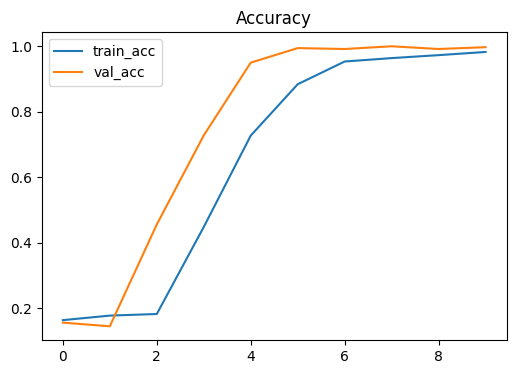

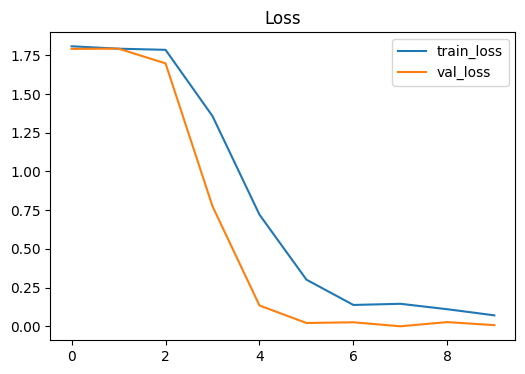

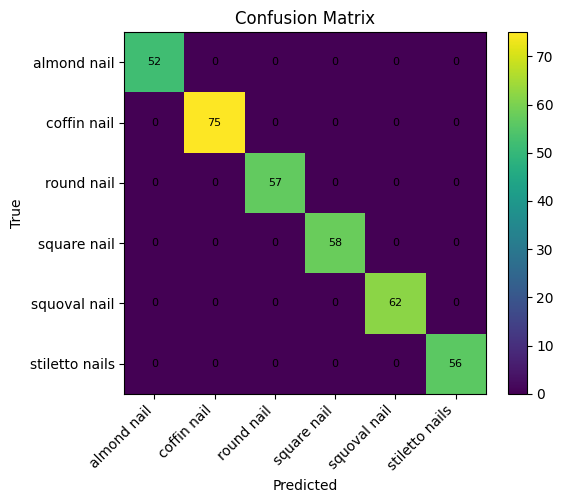

Saved: /content/drive/MyDrive/nail_results_selfcnn_3conv/SelfCNN_3conv_Results.docx 
Folder: /content/drive/MyDrive/nail_results_selfcnn_3conv


In [14]:
# ==== ÿ•ÿπÿØÿßÿØÿßÿ™ ÿ≥ÿ±Ÿäÿπÿ© (ÿ™ÿ™ÿ£ŸÉÿØ ÿ•ŸÜ ÿßŸÑŸÖÿ™ÿ∫Ÿäÿ±ÿßÿ™ ŸÖŸàÿ¨ŸàÿØÿ©) ====
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, itertools, glob
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from docx import Document
from docx.shared import Inches
from pathlib import Path

# ŸÖÿ≥ÿßÿ± ÿßŸÑÿØÿßÿ™ÿß
dataset_path = globals().get("dataset_path", "/content/drive/MyDrive/nail_dataset")
IMG_SIZE     = globals().get("IMG_SIZE", (224,224))
BATCH_SIZE   = globals().get("BATCH_SIZE", 32)
SEED         = globals().get("SEED", 123)

MODEL_NAME  = "SelfCNN_3conv"
results_dir = f"/content/drive/MyDrive/nail_results_{MODEL_NAME.lower()}"
os.makedirs(results_dir, exist_ok=True)

# ==== ÿØÿßŸÑÿ© ÿ®ŸÜÿßÿ° ÿßŸÑŸÖŸàÿØŸäŸÑ ====
def build_self_cnn(img_size, num_classes, num_conv_blocks=3, base_filters=32, dense_units=(256,128,64)):
    inputs = layers.Input(shape=img_size+(3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomFlip("horizontal")(x)
    filters = base_filters
    for _ in range(num_conv_blocks):
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)
        filters = min(filters*2, 256)
    x = layers.Flatten()(x)
    for u in dense_units:
        x = layers.Dense(u, activation="relu")(x)
        x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs, name=f"SelfCNN_{num_conv_blocks}conv")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# ==== ÿ™ÿ≠ŸÖŸäŸÑ ÿßŸÑÿ®ŸäÿßŸÜÿßÿ™ (ÿ®ÿØŸàŸÜ preprocess ÿÆÿßÿ±ÿ¨Ÿä ŸÑÿ£ŸÜ ÿßŸÑŸÖŸàÿØŸäŸÑ ŸäÿπŸÖŸÑ Rescaling ÿØÿßÿÆŸÑŸäŸãÿß) ====
AUTOTUNE = tf.data.AUTOTUNE
train_raw = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path, validation_split=0.2, subset="training",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
val_raw = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path, validation_split=0.2, subset="validation",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
class_names = train_raw.class_names
num_classes = len(class_names)
train_ds = train_raw.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_raw.cache().prefetch(AUTOTUNE)

# ==== ÿ®ŸÜÿßÿ° + ÿ™ÿØÿ±Ÿäÿ® ====
model = build_self_cnn(IMG_SIZE, num_classes, num_conv_blocks=3, base_filters=32, dense_units=(256,128,64))
ckpt_path = os.path.join(results_dir, f"best_{MODEL_NAME.lower()}.keras")
csv_log   = os.path.join(results_dir, "train_log.csv")
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, mode="max", verbose=1),
    tf.keras.callbacks.CSVLogger(csv_log),
]
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)

# ==== ÿßŸÑÿ™ŸÇŸäŸäŸÖ + ÿßŸÑÿ≠ŸÅÿ∏ ====
# ÿ™ÿ¨ŸÖŸäÿπ ÿµŸàÿ±/ŸÑŸäÿ®ŸÑÿßÿ™ ÿßŸÑŸÅÿßŸÑÿØŸäÿ¥ŸÜ
val_images, val_labels = [], []
for bx, by in val_ds:
    val_images.append(bx.numpy()); val_labels.append(by.numpy())
val_images = np.concatenate(val_images, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

probs  = model.predict(val_images, batch_size=BATCH_SIZE, verbose=0)
y_pred = probs.argmax(axis=1)
acc  = (y_pred == val_labels).mean()
loss = tf.keras.losses.sparse_categorical_crossentropy(val_labels, probs).numpy().mean()
precision_macro    = precision_score(val_labels, y_pred, average="macro",    zero_division=0)
precision_weighted = precision_score(val_labels, y_pred, average="weighted", zero_division=0)

# CSVs
report_df = pd.DataFrame(classification_report(val_labels, y_pred, target_names=class_names, output_dict=True)).transpose()
report_csv = os.path.join(results_dir, "classification_report.csv"); report_df.to_csv(report_csv)
cm = confusion_matrix(val_labels, y_pred, labels=range(num_classes))
cm_csv = os.path.join(results_dir, "confusion_matrix.csv"); np.savetxt(cm_csv, cm, fmt="%d", delimiter=",")

# ÿßŸÑŸÖŸÜÿ≠ŸÜŸäÿßÿ™
hist = history.history
acc_png  = os.path.join(results_dir, "accuracy_curve.png")
loss_png = os.path.join(results_dir, "loss_curve.png")
cm_png   = os.path.join(results_dir, "confusion_matrix.png")

plt.figure(figsize=(6,4)); plt.plot(hist["accuracy"], label="train_acc"); plt.plot(hist["val_accuracy"], label="val_acc"); plt.legend(); plt.title("Accuracy"); plt.savefig(acc_png, dpi=150, bbox_inches="tight"); plt.show()
plt.figure(figsize=(6,4)); plt.plot(hist["loss"], label="train_loss"); plt.plot(hist["val_loss"], label="val_loss"); plt.legend(); plt.title("Loss"); plt.savefig(loss_png, dpi=150, bbox_inches="tight"); plt.show()

plt.figure(figsize=(6,5)); plt.imshow(cm, interpolation='nearest'); plt.title("Confusion Matrix"); plt.colorbar()
ticks = np.arange(num_classes); plt.xticks(ticks, class_names, rotation=45, ha="right"); plt.yticks(ticks, class_names)
for i, j in itertools.product(range(num_classes), range(num_classes)): plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.savefig(cm_png, dpi=150, bbox_inches="tight"); plt.show()

# ŸÖŸÑÿÆÿµ ÿßŸÑÿØÿßÿ™ÿß (ÿπÿØÿØ ÿßŸÑÿµŸàÿ± + ŸÖÿ´ÿßŸÑ)
def list_images(folder):
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp"); files=[]
    for e in exts: files.extend(glob.glob(os.path.join(folder, e)))
    return sorted(files)
counts, samples = [], []
for cname in class_names:
    cdir = os.path.join(dataset_path, cname)
    files = list_images(cdir); counts.append(len(files)); samples.append(files[0] if files else "")
dataset_summary_df = pd.DataFrame({"Class Name": class_names, "Total Images": counts, "Sample Image Path": samples})
dataset_summary_csv = os.path.join(results_dir, "dataset_summary.csv"); dataset_summary_df.to_csv(dataset_summary_csv, index=False)

# Word
docx_path = os.path.join(results_dir, f"{MODEL_NAME}_Results.docx")
doc = Document(); doc.add_heading(f'{MODEL_NAME} Results', 1)
t = doc.add_table(rows=2, cols=4); hdr=t.rows[0].cells
hdr[0].text, hdr[1].text, hdr[2].text, hdr[3].text='Accuracy','Precision (macro)','Precision (weighted)','Loss'
row=t.rows[1].cells
row[0].text=f"{acc:.4f}"; row[1].text=f"{precision_macro:.4f}"; row[2].text=f"{precision_weighted:.4f}"; row[3].text=f"{loss:.4f}"
for p in [acc_png, loss_png, cm_png]:
    if os.path.exists(p): doc.add_picture(p, width=Inches(5.5))
doc.add_paragraph("Files:");
for p in [dataset_summary_csv, report_csv, cm_csv, csv_log]: doc.add_paragraph("- "+Path(p).name)
doc.save(docx_path)
print("Saved:", docx_path, "\nFolder:", results_dir)


## **SelfCNN ‚Äî 5 Conv / 5 Pool / 3 Dense**

Found 1800 files belonging to 6 classes.
Using 1440 files for training.
Found 1800 files belonging to 6 classes.
Using 360 files for validation.
Epoch 1/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 13s/step - accuracy: 0.1559 - loss: 1.8026 
Epoch 1: val_accuracy improved from -inf to 0.15833, saving model to /content/drive/MyDrive/nail_results_selfcnn_5conv/best_selfcnn_5conv.keras
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 669s 15s/step - accuracy: 0.1558 - loss: 1.8025 - val_accuracy: 0.1583 - val_loss: 1.7933
Epoch 2/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 13s/step - accuracy: 0.1897 - loss: 1.7915 
Epoch 2: val_accuracy did not improve from 0.15833
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 648s 14s/step - accuracy: 0.1896 - loss: 1.7915 - val_accuracy: 0.1444 - val_loss: 1.7937
Epoch 3/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 13s/step - accu

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


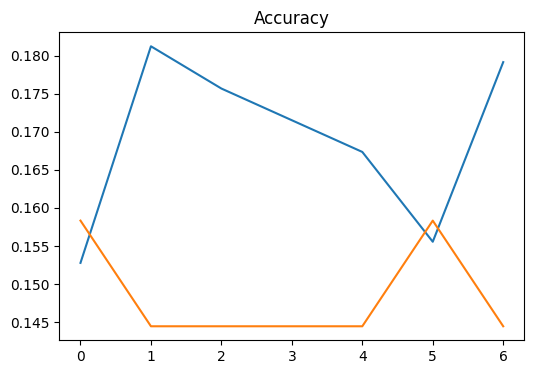

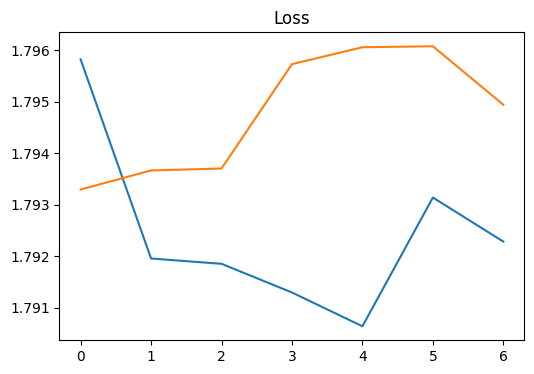

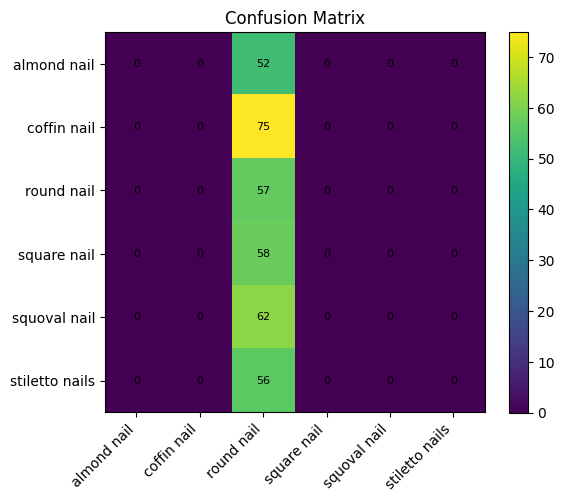

Saved: /content/drive/MyDrive/nail_results_selfcnn_5conv/SelfCNN_5conv_Results.docx 
Folder: /content/drive/MyDrive/nail_results_selfcnn_5conv


In [15]:
# ==== ÿ•ÿπÿØÿßÿØÿßÿ™ ====
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, itertools, glob
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from docx import Document
from docx.shared import Inches
from pathlib import Path

dataset_path = globals().get("dataset_path", "/content/drive/MyDrive/nail_dataset")
IMG_SIZE     = globals().get("IMG_SIZE", (224,224))
BATCH_SIZE   = globals().get("BATCH_SIZE", 32)
SEED         = globals().get("SEED", 123)

MODEL_NAME  = "SelfCNN_5conv"
results_dir = f"/content/drive/MyDrive/nail_results_{MODEL_NAME.lower()}"
os.makedirs(results_dir, exist_ok=True)

def build_self_cnn(img_size, num_classes, num_conv_blocks=5, base_filters=32, dense_units=(256,128,64)):
    inputs = layers.Input(shape=img_size+(3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomFlip("horizontal")(x)
    filters = base_filters
    for _ in range(num_conv_blocks):
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)
        filters = min(filters*2, 256)
    x = layers.Flatten()(x)
    for u in dense_units:
        x = layers.Dense(u, activation="relu")(x); x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs, name=f"SelfCNN_{num_conv_blocks}conv")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

AUTOTUNE = tf.data.AUTOTUNE
train_raw = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split=0.2, subset="training",
                                                                seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
val_raw   = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split=0.2, subset="validation",
                                                                seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
class_names = train_raw.class_names; num_classes=len(class_names)
train_ds = train_raw.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_raw.cache().prefetch(AUTOTUNE)

model = build_self_cnn(IMG_SIZE, num_classes, num_conv_blocks=5, base_filters=32, dense_units=(256,128,64))
ckpt_path = os.path.join(results_dir, f"best_{MODEL_NAME.lower()}.keras")
csv_log   = os.path.join(results_dir, "train_log.csv")
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, mode="max", verbose=1),
    tf.keras.callbacks.CSVLogger(csv_log),
]
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)

# ======= ÿßŸÑÿ™ŸÇŸäŸäŸÖ ŸàÿßŸÑÿ≠ŸÅÿ∏ (ŸÜŸÅÿ≥ ŸÖÿß ÿ≥ÿ®ŸÇ) =======
val_images, val_labels = [], []
for bx, by in val_ds: val_images.append(bx.numpy()); val_labels.append(by.numpy())
val_images = np.concatenate(val_images, 0); val_labels = np.concatenate(val_labels, 0)
probs  = model.predict(val_images, batch_size=BATCH_SIZE, verbose=0); y_pred = probs.argmax(1)
acc  = (y_pred == val_labels).mean()
loss = tf.keras.losses.sparse_categorical_crossentropy(val_labels, probs).numpy().mean()
precision_macro    = precision_score(val_labels, y_pred, average="macro",    zero_division=0)
precision_weighted = precision_score(val_labels, y_pred, average="weighted", zero_division=0)

report_df = pd.DataFrame(classification_report(val_labels, y_pred, target_names=class_names, output_dict=True)).transpose()
report_csv = os.path.join(results_dir, "classification_report.csv"); report_df.to_csv(report_csv)
cm = confusion_matrix(val_labels, y_pred, labels=range(num_classes))
cm_csv = os.path.join(results_dir, "confusion_matrix.csv"); np.savetxt(cm_csv, cm, fmt="%d", delimiter=",")
hist = history.history
acc_png  = os.path.join(results_dir, "accuracy_curve.png")
loss_png = os.path.join(results_dir, "loss_curve.png")
cm_png   = os.path.join(results_dir, "confusion_matrix.png")
plt.figure(figsize=(6,4)); plt.plot(hist["accuracy"]); plt.plot(hist["val_accuracy"]); plt.title("Accuracy"); plt.savefig(acc_png, dpi=150, bbox_inches="tight"); plt.show()
plt.figure(figsize=(6,4)); plt.plot(hist["loss"]); plt.plot(hist["val_loss"]); plt.title("Loss"); plt.savefig(loss_png, dpi=150, bbox_inches="tight"); plt.show()
plt.figure(figsize=(6,5)); plt.imshow(cm); plt.title("Confusion Matrix"); plt.colorbar();
ticks=np.arange(num_classes); plt.xticks(ticks, class_names, rotation=45, ha="right"); plt.yticks(ticks, class_names)
for i,j in itertools.product(range(num_classes), range(num_classes)): plt.text(j,i,cm[i,j],ha="center",va="center",fontsize=8)
plt.tight_layout(); plt.savefig(cm_png, dpi=150, bbox_inches="tight"); plt.show()

def list_images(folder):
    exts=("*.jpg","*.jpeg","*.png","*.bmp","*.webp"); files=[];
    for e in exts: files.extend(glob.glob(os.path.join(folder, e)));
    return sorted(files)
counts,samples=[],[]
for cname in class_names:
    cdir=os.path.join(dataset_path,cname); files=list_images(cdir); counts.append(len(files)); samples.append(files[0] if files else "")
dataset_summary_df=pd.DataFrame({"Class Name":class_names,"Total Images":counts,"Sample Image Path":samples})
dataset_summary_csv=os.path.join(results_dir,"dataset_summary.csv"); dataset_summary_df.to_csv(dataset_summary_csv,index=False)

docx_path=os.path.join(results_dir,f"{MODEL_NAME}_Results.docx")
doc=Document(); doc.add_heading(f'{MODEL_NAME} Results',1)
t=doc.add_table(rows=2,cols=4); hdr=t.rows[0].cells; hdr[0].text, hdr[1].text, hdr[2].text, hdr[3].text='Accuracy','Precision (macro)','Precision (weighted)','Loss'
row=t.rows[1].cells; row[0].text=f"{acc:.4f}"; row[1].text=f"{precision_macro:.4f}"; row[2].text=f"{precision_weighted:.4f}"; row[3].text=f"{loss:.4f}"
for p in [acc_png,loss_png,cm_png]:
    if os.path.exists(p): doc.add_picture(p, width=Inches(5.5))
for p in [dataset_summary_csv, report_csv, cm_csv, csv_log]: doc.add_paragraph("- "+Path(p).name)
doc.save(docx_path); print("Saved:", docx_path, "\nFolder:", results_dir)


## **SelfCNN ‚Äî 7 Conv / 7 Pool / 3 Dense**

Found 1800 files belonging to 6 classes.
Using 1440 files for training.
Found 1800 files belonging to 6 classes.
Using 360 files for validation.
Epoch 1/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15s/step - accuracy: 0.1586 - loss: 1.7935 
Epoch 1: val_accuracy improved from -inf to 0.14444, saving model to /content/drive/MyDrive/nail_results_selfcnn_7conv/best_selfcnn_7conv.keras
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 800s 17s/step - accuracy: 0.1585 - loss: 1.7935 - val_accuracy: 0.1444 - val_loss: 1.7934
Epoch 2/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15s/step - accuracy: 0.1745 - loss: 1.7912 
Epoch 2: val_accuracy did not improve from 0.14444
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 756s 17s/step - accuracy: 0.1743 - loss: 1.7912 - val_accuracy: 0.1444 - val_loss: 1.7931
Epoch 3/10
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15s/step - accu

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


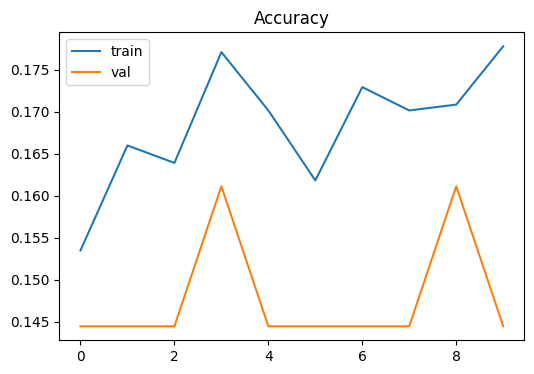

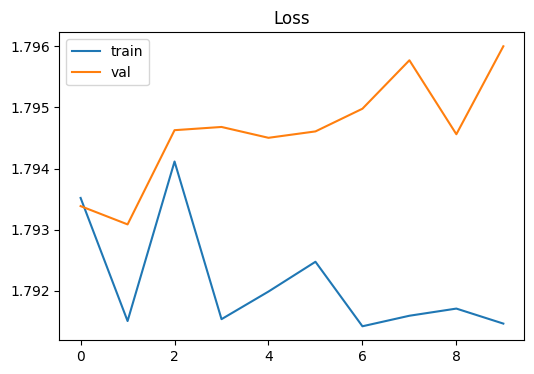

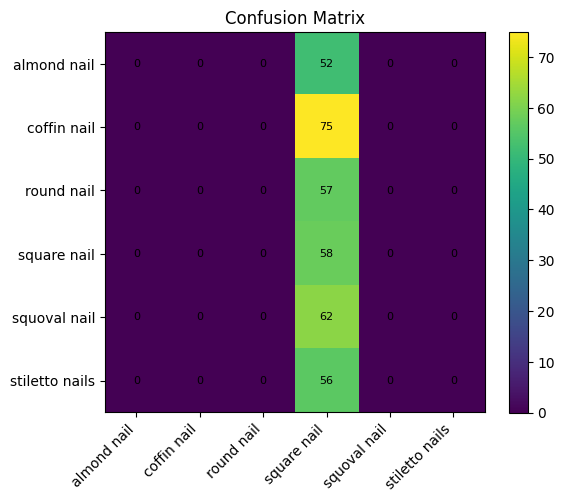

‚úÖ Saved: /content/drive/MyDrive/nail_results_selfcnn_7conv/SelfCNN_7conv_Results.docx 
üìÇ Folder: /content/drive/MyDrive/nail_results_selfcnn_7conv


In [18]:
# ================= ÿ™ÿ´ÿ®Ÿäÿ™ ÿßŸÑÿ≠ÿ≤ŸÖ ÿßŸÑŸÜÿßŸÇÿµÿ© =================
!pip install -q python-docx

# ================= ÿßŸÑÿßÿ≥ÿ™Ÿäÿ±ÿßÿØÿßÿ™ =================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, itertools, glob
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from docx import Document
from docx.shared import Inches
from pathlib import Path

# ================= ÿ•ÿπÿØÿßÿØÿßÿ™ =================
dataset_path = globals().get("dataset_path", "/content/drive/MyDrive/nail_dataset")
IMG_SIZE     = globals().get("IMG_SIZE", (224,224))
BATCH_SIZE   = globals().get("BATCH_SIZE", 32)
SEED         = globals().get("SEED", 123)

MODEL_NAME  = "SelfCNN_7conv"
results_dir = f"/content/drive/MyDrive/nail_results_{MODEL_NAME.lower()}"
os.makedirs(results_dir, exist_ok=True)

# ================= ÿ®ŸÜÿßÿ° ÿßŸÑŸÖŸàÿØŸäŸÑ =================
def build_self_cnn(img_size, num_classes, num_conv_blocks=7, base_filters=32, dense_units=(256,128,64)):
    inputs = layers.Input(shape=img_size+(3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomFlip("horizontal")(x)
    filters = base_filters
    for _ in range(num_conv_blocks):
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)
        filters = min(filters*2, 256)
    x = layers.Flatten()(x)
    for u in dense_units:
        x = layers.Dense(u, activation="relu")(x); x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs, name=f"SelfCNN_{num_conv_blocks}conv")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# ================= ÿ™ÿ≠ŸÖŸäŸÑ ÿßŸÑÿ®ŸäÿßŸÜÿßÿ™ =================
AUTOTUNE = tf.data.AUTOTUNE
train_raw = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path, validation_split=0.2, subset="training",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
val_raw = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path, validation_split=0.2, subset="validation",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
class_names = train_raw.class_names; num_classes=len(class_names)
train_ds = train_raw.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_raw.cache().prefetch(AUTOTUNE)

# ================= ÿ™ÿØÿ±Ÿäÿ® =================
model = build_self_cnn(IMG_SIZE, num_classes, num_conv_blocks=7, base_filters=32, dense_units=(256,128,64))
ckpt_path = os.path.join(results_dir, f"best_{MODEL_NAME.lower()}.keras")
csv_log   = os.path.join(results_dir, "train_log.csv")
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True, mode="max", verbose=1),
    tf.keras.callbacks.CSVLogger(csv_log),
]
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)

# ================= ÿßŸÑÿ™ŸÇŸäŸäŸÖ =================
val_images, val_labels = [], []
for bx, by in val_ds:
    val_images.append(bx.numpy()); val_labels.append(by.numpy())
val_images = np.concatenate(val_images, 0); val_labels = np.concatenate(val_labels, 0)
probs  = model.predict(val_images, batch_size=BATCH_SIZE, verbose=0)
y_pred = probs.argmax(1)

acc  = (y_pred == val_labels).mean()
loss = tf.keras.losses.sparse_categorical_crossentropy(val_labels, probs).numpy().mean()
precision_macro    = precision_score(val_labels, y_pred, average="macro",    zero_division=0)
precision_weighted = precision_score(val_labels, y_pred, average="weighted", zero_division=0)

# ================= ÿßŸÑÿ≠ŸÅÿ∏ (CSV/ÿµŸàÿ±/Word) =================
report_df = pd.DataFrame(classification_report(val_labels, y_pred, target_names=class_names, output_dict=True)).transpose()
report_csv = os.path.join(results_dir, "classification_report.csv"); report_df.to_csv(report_csv)

cm = confusion_matrix(val_labels, y_pred, labels=range(num_classes))
cm_csv = os.path.join(results_dir, "confusion_matrix.csv"); np.savetxt(cm_csv, cm, fmt="%d", delimiter=",")

hist = history.history
acc_png  = os.path.join(results_dir, "accuracy_curve.png")
loss_png = os.path.join(results_dir, "loss_curve.png")
cm_png   = os.path.join(results_dir, "confusion_matrix.png")

plt.figure(figsize=(6,4)); plt.plot(hist["accuracy"],label="train"); plt.plot(hist["val_accuracy"],label="val"); plt.legend(); plt.title("Accuracy"); plt.savefig(acc_png, dpi=150, bbox_inches="tight"); plt.show()
plt.figure(figsize=(6,4)); plt.plot(hist["loss"],label="train"); plt.plot(hist["val_loss"],label="val"); plt.legend(); plt.title("Loss"); plt.savefig(loss_png, dpi=150, bbox_inches="tight"); plt.show()
plt.figure(figsize=(6,5)); plt.imshow(cm); plt.title("Confusion Matrix"); plt.colorbar()
ticks=np.arange(num_classes); plt.xticks(ticks,class_names,rotation=45,ha="right"); plt.yticks(ticks,class_names)
for i,j in itertools.product(range(num_classes),range(num_classes)): plt.text(j,i,cm[i,j],ha="center",va="center",fontsize=8)
plt.tight_layout(); plt.savefig(cm_png, dpi=150, bbox_inches="tight"); plt.show()

def list_images(folder):
    exts=("*.jpg","*.jpeg","*.png","*.bmp","*.webp"); files=[]
    for e in exts: files.extend(glob.glob(os.path.join(folder,e)))
    return sorted(files)
counts,samples=[],[]
for cname in class_names:
    cdir=os.path.join(dataset_path,cname); files=list_images(cdir); counts.append(len(files)); samples.append(files[0] if files else "")
dataset_summary_df=pd.DataFrame({"Class Name":class_names,"Total Images":counts,"Sample Image Path":samples})
dataset_summary_csv=os.path.join(results_dir,"dataset_summary.csv"); dataset_summary_df.to_csv(dataset_summary_csv,index=False)

docx_path=os.path.join(results_dir,f"{MODEL_NAME}_Results.docx")
doc=Document(); doc.add_heading(f'{MODEL_NAME} Results',1)
t=doc.add_table(rows=2,cols=4); hdr=t.rows[0].cells
hdr[0].text,hdr[1].text,hdr[2].text,hdr[3].text='Accuracy','Precision (macro)','Precision (weighted)','Loss'
row=t.rows[1].cells; row[0].text=f"{acc:.4f}"; row[1].text=f"{precision_macro:.4f}"; row[2].text=f"{precision_weighted:.4f}"; row[3].text=f"{loss:.4f}"
for p in [acc_png,loss_png,cm_png]:
    if os.path.exists(p): doc.add_picture(p, width=Inches(5.5))
for p in [dataset_summary_csv, report_csv, cm_csv, csv_log]: doc.add_paragraph("- "+Path(p).name)
doc.save(docx_path)
print("‚úÖ Saved:", docx_path, "\nüìÇ Folder:", results_dir)


In [2]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [3]:
!ls -la "/content/drive/MyDrive"


ls: /content/drive/MyDrive/cat_dog: No such file or directory
ls: /content/drive/MyDrive/nail_dataset: No such file or directory
total 336796
-rw------- 1 root root       175 May 16  2018 '2018 Calendar.gsheet'
lrw------- 1 root root         0 Aug 20 08:46  cat_dog -> /content/drive/.shortcut-targets-by-id/10TpvvTU_ug-AVq-esvpXFPIFbpmFzCIT/cat_dog
drwx------ 2 root root      4096 Jun 30 07:18 'Colab Notebooks'
-rw------- 1 root root   1560010 Sep 28  2016 'Getting started.pdf'
lrw------- 1 root root         0 Aug 30 18:06  nail_dataset -> /content/drive/.shortcut-targets-by-id/1Pz-305-kwlDUcPfuPVNhf-68JxHjWFKX/nail_dataset
drwx------ 2 root root      4096 Sep  5 21:52  nail_results_resnet101
drwx------ 2 root root      4096 Sep  5 21:13  nail_results_resnet50
drwx------ 2 root root      4096 Sep  7 00:08  nail_results_selfcnn_3conv
drwx------ 2 root root      4096 Sep  7 01:55  nail_results_selfcnn_5conv
drwx------ 2 root root      4096 Sep  7 03:12  nail_results_selfcnn_7conv
drwx----

In [6]:
# ‚úÖ ÿ™ÿ≠ÿØŸäÿ´ ŸÖŸÑŸÅÿßÿ™ ÿßŸÑŸÄ Word ÿ®ÿ•ÿ∂ÿßŸÅÿ© ÿßŸÑŸÄ Precision ÿ®ÿØŸàŸÜ ÿ•ÿπÿßÿØÿ© ÿ™ÿØÿ±Ÿäÿ®
!pip -q install python-docx

import os, numpy as np, pandas as pd, datetime as dt, tensorflow as tf
from sklearn.metrics import precision_score, classification_report
from docx import Document
from docx.shared import Inches

# ---- ÿ•ÿπÿØÿßÿØÿßÿ™ ŸÖÿ∑ÿßÿ®ŸÇÿ© ŸÑŸÑŸä ÿØÿ±Ÿëÿ®ÿ™Ÿä ÿ®Ÿáÿß ----
dataset_path = globals().get("dataset_path", "/content/drive/MyDrive/nail_dataset")
IMG_SIZE     = globals().get("IMG_SIZE", (224,224))
BATCH_SIZE   = globals().get("BATCH_SIZE", 32)
SEED         = globals().get("SEED", 123)

# ŸÖÿ¨ŸÑÿØÿßÿ™ ÿßŸÑŸÜÿ™ÿßÿ¶ÿ¨ (ÿπÿØŸëŸÑŸäŸáÿß ÿ•ÿ∞ÿß ŸÖÿ≥ÿßÿ±ÿßÿ™ŸÉ ŸÖÿÆÿ™ŸÑŸÅÿ©)
models_info = [
    ("SelfCNN_3conv", "/content/drive/MyDrive/nail_results_selfcnn_3conv"),
    ("SelfCNN_5conv", "/content/drive/MyDrive/nail_results_selfcnn_5conv"),
    ("SelfCNN_7conv", "/content/drive/MyDrive/nail_results_selfcnn_7conv"),
]

# ---- ÿ™ÿ¨ŸáŸäÿ≤ ÿ®ŸäÿßŸÜÿßÿ™ ÿßŸÑÿ™ÿ≠ŸÇŸÇ ŸÖÿ±ÿ© Ÿàÿßÿ≠ÿØÿ© ÿ®ŸÜŸÅÿ≥ ÿßŸÑÿ™ŸÇÿ≥ŸäŸÖ 20% ----
def make_val_arrays(dataset_path, IMG_SIZE, BATCH_SIZE, SEED):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        validation_split=0.2, subset="validation",
        seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE,
        shuffle=False
    )
    class_names = ds.class_names
    xs, ys = [], []
    for bx, by in ds:
        xs.append(bx.numpy()); ys.append(by.numpy())
    xs = np.concatenate(xs, axis=0)
    ys = np.concatenate(ys, axis=0).astype(int)
    return xs, ys, class_names

val_images, val_labels, class_names = make_val_arrays(dataset_path, IMG_SIZE, BATCH_SIZE, SEED)
num_classes = len(class_names)
all_labels_list = list(range(num_classes))

# ---- ÿØÿßŸÑÿ© ÿµÿ∫Ÿäÿ±ÿ©: ÿ™ÿ∂ŸäŸÅ ÿ¨ÿØŸàŸÑ Precision ÿ•ŸÑŸâ ŸÖŸÑŸÅ Word ŸÖŸàÿ¨ŸàÿØ ÿ£Ÿà ÿ™ÿ®ŸÜŸä Ÿàÿßÿ≠ÿØ ÿ¨ÿØŸäÿØ ----
def append_precision_to_docx(docx_path, model_name, class_names, per_class_prec, macro_p, weighted_p):
    # ŸÑŸà ÿßŸÑŸÖŸÑŸÅ ŸÖŸàÿ¨ŸàÿØ ŸÜŸÅÿ™ÿ≠ÿå ÿ∫Ÿäÿ± ŸÉÿ∞ÿß ŸÜŸÜÿ¥ÿ¶ ÿ¨ÿØŸäÿØ
    if os.path.exists(docx_path):
        doc = Document(docx_path)
    else:
        doc = Document()
        doc.add_heading(f'{model_name} Results', level=1)

    # ÿπŸÜŸàÿßŸÜ ÿßŸÑÿ™ÿ≠ÿØŸäÿ´ + ŸàŸÇÿ™ ÿßŸÑÿ™ÿ¥ÿ∫ŸäŸÑ
    doc.add_heading('Precision (post-run update)', level=2)
    doc.add_paragraph(dt.datetime.now().strftime("Updated at: %Y-%m-%d %H:%M:%S"))

    # ÿ¨ÿØŸàŸÑ ÿßŸÑŸÖŸÑÿÆÿµ
    t0 = doc.add_table(rows=2, cols=3)
    hdr = t0.rows[0].cells
    hdr[0].text, hdr[1].text, hdr[2].text = 'Metric', 'Value', 'Note'
    r = t0.rows[1].cells
    r[0].text = 'Precision (macro) / Precision (weighted)'
    r[1].text = f"{macro_p:.4f} / {weighted_p:.4f}"
    r[2].text = 'Computed without retraining'

    doc.add_paragraph()

    # ÿ¨ÿØŸàŸÑ per-class
    t = doc.add_table(rows=1+len(class_names), cols=2)
    t.style = 'Table Grid'
    t.rows[0].cells[0].text = 'Class'
    t.rows[0].cells[1].text = 'Precision'
    for i, cls in enumerate(class_names):
        t.rows[i+1].cells[0].text = cls
        t.rows[i+1].cells[1].text = f"{per_class_prec.get(cls, 0.0):.4f}"

    # ÿ≠ŸÅÿ∏ ŸÜÿ≥ÿÆÿ© ŸÖÿ≠ÿØÿ´ÿ© ÿ®ÿßÿ≥ŸÖ ÿ¨ÿØŸäÿØ ÿ≠ÿ™Ÿâ ŸÖÿß ŸÜŸÉÿ™ÿ® ŸÅŸàŸÇ ÿßŸÑŸÇÿØŸäŸÖÿ©
    updated_path = docx_path.replace(".docx", "_updated.docx")
    doc.save(updated_path)
    return updated_path

# ---- ÿ≠ÿ≥ÿßÿ® Precision + ÿ™ÿ≠ÿØŸäÿ´ Word ŸÑŸÉŸÑ ŸÖŸàÿØŸäŸÑ ----
summary_rows = []
for model_name, results_dir in models_info:
    best_path = os.path.join(results_dir, f"best_{model_name.lower()}.keras")
    if not os.path.exists(best_path):
        print(f"‚ö†Ô∏è ŸÑŸÖ Ÿäÿ™ŸÖ ÿßŸÑÿπÿ´Ÿàÿ± ÿπŸÑŸâ {best_path} ‚Äî ÿ™ÿÆÿ∑ŸëŸä")
        continue

    print(f"\n===== {model_name} =====")
    # ÿ™ÿ≠ŸÖŸäŸÑ ÿ£ŸÅÿ∂ŸÑ Ÿàÿ≤ŸÜ
    model = tf.keras.models.load_model(best_path, compile=False)

    # ÿ™ŸÜÿ®ÿ§ ÿπŸÑŸâ ÿßŸÑŸÅÿßŸÑÿØŸäÿ¥ŸÜ
    probs = model.predict(val_images, batch_size=BATCH_SIZE, verbose=0)
    y_pred = probs.argmax(axis=1).astype(int)

    # Precision ÿπÿßŸÖ + ŸÑŸÉŸÑ ŸÅÿ¶ÿ© (ŸÜÿ≠ÿØÿØ ÿßŸÑŸÅÿ¶ÿßÿ™ ÿµÿ±ÿßÿ≠ÿ© ŸÑÿ™ŸÅÿßÿØŸä ÿ£ÿÆÿ∑ÿßÿ° ÿßÿÆÿ™ŸÑÿßŸÅ ÿßŸÑÿπÿØÿØ)
    precision_macro    = precision_score(val_labels, y_pred, labels=all_labels_list, average="macro",    zero_division=0)
    precision_weighted = precision_score(val_labels, y_pred, labels=all_labels_list, average="weighted", zero_division=0)

    rep = classification_report(
        val_labels, y_pred,
        labels=all_labels_list,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    per_class_prec = {cls: float(rep[cls]["precision"]) for cls in class_names}

    # ÿ™ÿ≠ÿØŸäÿ´/ÿ•ŸÜÿ¥ÿßÿ° ŸÖŸÑŸÅ ÿßŸÑŸÄ Word
    docx_path = os.path.join(results_dir, f"{model_name}_Results.docx")
    updated_path = append_precision_to_docx(docx_path, model_name, class_names, per_class_prec, precision_macro, precision_weighted)

    # ÿ≠ŸÅÿ∏ CSV ŸÖÿÆÿ™ÿµÿ± ŸÉÿ∞ŸÑŸÉ (ÿßÿÆÿ™Ÿäÿßÿ±Ÿä)
    rows = [{"Model": model_name, "Type": "macro", "Precision": precision_macro},
            {"Model": model_name, "Type": "weighted", "Precision": precision_weighted}]
    for cls in class_names:
        rows.append({"Model": model_name, "Type": f"class:{cls}", "Precision": per_class_prec[cls]})
    pd.DataFrame(rows).to_csv(os.path.join(results_dir, "precision_only.csv"), index=False)

    print(f"‚úÖ Updated Word: {updated_path}")
    summary_rows.append({"Model": model_name, "Precision_macro": precision_macro, "Precision_weighted": precision_weighted})

# ÿ¨ÿØŸàŸÑ ŸÖŸÑÿÆŸëÿµ ÿ≥ÿ±Ÿäÿπ ÿπŸÑŸâ ÿßŸÑÿ¥ÿßÿ¥ÿ©
if summary_rows:
    display(pd.DataFrame(summary_rows))


   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 253.0/253.0 kB 3.7 MB/s eta 0:00:00
Found 1800 files belonging to 6 classes.
Using 360 files for validation.

===== SelfCNN_3conv =====
‚úÖ Updated Word: /content/drive/MyDrive/nail_results_selfcnn_3conv/SelfCNN_3conv_Results_updated.docx

===== SelfCNN_5conv =====
‚úÖ Updated Word: /content/drive/MyDrive/nail_results_selfcnn_5conv/SelfCNN_5conv_Results_updated.docx

===== SelfCNN_7conv =====
‚úÖ Updated Word: /content/drive/MyDrive/nail_results_selfcnn_7conv/SelfCNN_7conv_Results_updated.docx


Model  Precision_macro  Precision_weighted
0  SelfCNN_3conv         0.333333                 1.0
1  SelfCNN_5conv         0.000000                 0.0
2  SelfCNN_7conv         0.000000                 0.0